This is just a test

In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, SimpleRNN, RepeatVector, TimeDistributed, Dense, Input, Lambda
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
ALPHABET = '0123456789- '
DIGITS = 3
TRAINING_SERIES_LEN = 3

In [ ]:
HIDDEN_SIZE = 256
EPOCHS = 50
ALPHABET_LENGTH = len(ALPHABET)
MAXLEN = (DIGITS + 1) * TRAINING_SERIES_LEN + (TRAINING_SERIES_LEN - 1) 

In [ ]:
class OneHot(object):
    def __init__(self, characters):
        self.chars = sorted(set(characters))
        self.char_to_index = dict((char, i) for i, char in enumerate(self.chars))
        self.index_to_char = dict((i, char) for i, char in enumerate(self.chars))

    def encode(self, string, length):
        enc = np.zeros((length, len(self.chars)))
        for i, char in enumerate(string):
            enc[i, self.char_to_index[char]] = 1
        for i in range(len(string), length):
            enc[i, self.char_to_index[' ']] = 1
        return enc
    
    def decode(self, mat):            
        return "".join([self.decode_line(mat[x]) for x in range(mat.shape[0])])
    
    def decode_line(self, vec):
        return self.index_to_char[np.argmax(vec)]

In [ ]:
def create_data(size, train_series_len, max_exp=9, min_factor=-9, max_factor=9, digits=DIGITS):
    X = []
    y = []
    hist = []
    max_value = 10 ** digits - 1
    min_value = -max_value
    value_store = set()
    while len(X) < size:
        max_exp = np.random.randint(low=1, high=max_exp + 1)
        factors = np.random.randint(low=min_factor, high=max_factor + 1, size=max_exp + 1)
        
        fun = lambda _i: sum(f * (_i ** x) for x, f in enumerate(factors))
        
        series = tuple(fun(i) for i in range(train_series_len + 1))
        
        if not series in value_store and all(min_value <= x <= max_value for x in series):
            X.append(" ".join([str(x) for x in series[:-1]]))
            y.append(str(series[-1]))
        
    return X, y

In [ ]:
X, y = create_data(500000, TRAINING_SERIES_LEN)

encoder = OneHot(ALPHABET)
for i in range(len(X)):
    X[i] = encoder.encode(X[i], MAXLEN)
    y[i] = encoder.encode(y[i], DIGITS + 1)
    
print(f"Created {len(X)} data points")

Created 500000 data points


In [ ]:
X = np.array(X)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)

X_train: (400000, 14, 12)
y_train: (400000, 4, 12)
X_val  : (100000, 14, 12)
y_val  : (100000, 4, 12)


In [ ]:
lstn_input_shape = (MAXLEN, ALPHABET_LENGTH)
print(lstn_input_shape)

def create_model():

    _model = Sequential()
    _model.add(LSTM(HIDDEN_SIZE, input_shape=lstn_input_shape)) # Encoder
    _model.add(RepeatVector(DIGITS + 1))  # Stellt dem RNN im nächsten Schritt die Ausgabe des vorherigen bereit
    _model.add(LSTM(HIDDEN_SIZE, return_sequences=True)) # Decoder
    _model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax'))) # Wendet eine `Dense` Schicht auf jede Ausgabe des Decoders an
                                    # und ermittelt mittels 'softmax'-Funktion die Auswahlwahrscheinlichkeiten der Zeichen
    _model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return _model

(14, 12)


In [ ]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [ ]:
def train(model, X_train, y_train, X_val, y_val, encoder, epochs):
    loss, acc, val_loss, val_acc = [], [], [], []
    for iteration in range(1, epochs + 1):
        print('-' * 50)
        print('Iteration', iteration)
        #print("X_train:", X_train.shape, "; y_train:", y_train.shape)
        hist = model.fit(X_train, y_train,
                  batch_size=1000,
                  epochs=1,
                  validation_data=(X_val, y_val))
        loss.append(hist.history['loss'])
        acc.append(hist.history['accuracy'])
        val_loss.append(hist.history['val_loss'])
        val_acc.append(hist.history['val_accuracy'])
        if iteration % 5 == 0:
            for i in range(10):
                ind = np.random.randint(0, X_val.shape[0])
                rowx, rowy = X_val[ind], y_val[ind]
                #print("rowx:", rowx.shape, "; rowy:", rowy.shape)
                strx = ''
                for seqx in rowx:
                    strx += encoder.decode_line(seqx)
                stry = ''
                for seqy in rowy:
                    stry += encoder.decode_line(seqy)
                preds = model.predict_classes(np.array([rowx]), verbose=0)
                strpred = ''
                for p in preds[0]:
                    strpred += encoder.index_to_char[p]
                if stry.strip() == strpred.strip():
                    print('{}{} = {} ☑ {}{}'.format(colors.ok, strx, stry, strpred, colors.close))
                else:
                    print('{}{} = {} ☒ {}{}'.format(colors.fail, strx, stry, strpred, colors.close))
    return loss, acc, val_loss, val_acc

In [ ]:
model = create_model()

print("Training model:")
print(model.summary())

loss, acc, val_loss, val_acc = train(model, X_train, y_train, X_val, y_val, encoder, EPOCHS)

Training model:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 256)               275456    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 256)            525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             3084      
Total params: 803,852
Trainable params: 803,852
Non-trainable params: 0
_________________________________________________________________
None
--------------------------------------------------
Iteration 1
400/400 [==============================] - 10s 20ms/step - loss: 1.2294 - accuracy: 0.5956 - val_loss: 0.4325 - val_accuracy: 0.8505
-----------------------------

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


-5 -12 -19     = -26  ☑ -26 
6 13 20        = 27   ☑ 27  
6 6 6          = 6    ☑ 6   
-1 0 1         = 2    ☑ 2   
-2 -4 -6       = -8   ☑ -8  
-5 -9 -13      = -17  ☑ -17 
9 9 9          = 9    ☑ 9   
3 5 7          = 9    ☑ 9   
5 -2 -9        = -16  ☑ -16 
4 6 8          = 10   ☑ 10  
--------------------------------------------------
Iteration 6
400/400 [==============================] - 7s 19ms/step - loss: 3.2588e-04 - accuracy: 1.0000 - val_loss: 2.3953e-04 - val_accuracy: 1.0000
--------------------------------------------------
Iteration 7
400/400 [==============================] - 7s 19ms/step - loss: 2.1970e-04 - accuracy: 1.0000 - val_loss: 1.6183e-04 - val_accuracy: 1.0000
--------------------------------------------------
Iteration 8
400/400 [==============================] - 7s 18ms/step - loss: 1.5958e-04 - accuracy: 1.0000 - val_loss: 1.1467e-04 - val_accuracy: 1.0000
--------------------------------------------------
Iteration 9
400/400 [=============================

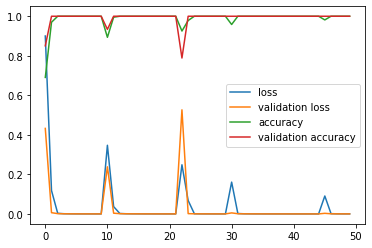

In [ ]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='validation loss')
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
test_string = "-100 70 80"

encoded = encoder.encode(test_string, MAXLEN)

result = model.predict(np.array([encoded]))

print(np.argmax(result[0], axis=1))
print(encoder.decode(result[0]))

[ 3 10  0  0]
18  


In [ ]:
widgets.Text(value='Hello World', placeholder='Type something', description='String:', disabled=False)